In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
import torch
import torch.nn as nn
from  torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
from pyret.filtertools import decompose
from fnn.utils import select_model
from fnn.config import get_custom_cfg
from fnn.data import TestDataset, ValidationDataset
import fnn.models as models
from fnn.evaluation import *
from fnn.distributions import *
from fnn.notebook.utils import *
from fnn.notebook.utils_discrim import *

In [3]:
file_path = '/home/xhding/tem_stim/16-05-31/naturalscene_test.h5'
cells = list(range(8))
t_list = [3, 3, 4, 4, 3, 4, 3, 3]
recording = recording_stats(file_path, cells)
single_trial_bin = recording.single_trial_bin

In [5]:
device = torch.device('cuda:0')
cfg = get_custom_cfg('fc_phase2_16-05-31')
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack_FC_2/epoch_050_loss_-33.40_pearson_0.9593.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=500)
test_pc, pred, targ = pearsonr_batch_eval(model, test_data, 8, device)

w = model.ganglion[-1].w.data.cpu().numpy()
w = w.reshape(8, 18, 18)
true_idxs = np.where(w == 1)

b = model.ganglion[3].bias.data.reshape((8,18,18))
b_true = b[true_idxs[0], true_idxs[1], true_idxs[2]]
b = torch.zeros_like(b) + b_true[:,None,None]
model.ganglion[3].bias.data = b.flatten()

w = model.ganglion[3].weight.data.reshape((8,18,18))
w_true = w[true_idxs[0], true_idxs[1], true_idxs[2]]
w = torch.zeros_like(w) + w_true[:,None,None]
model.ganglion[3].weight.data = w.flatten()

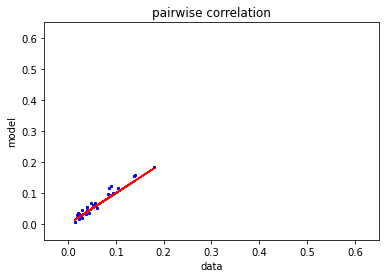

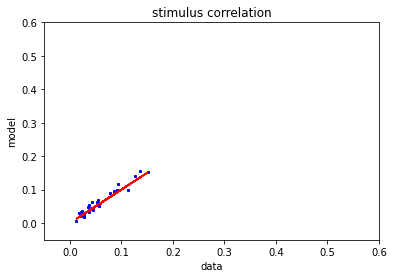

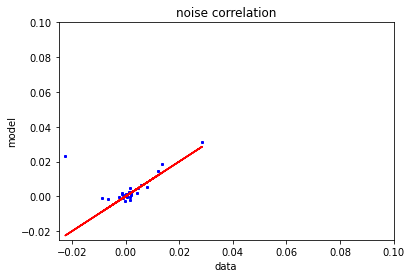

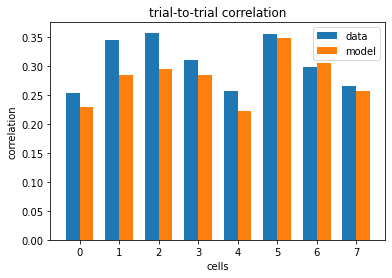

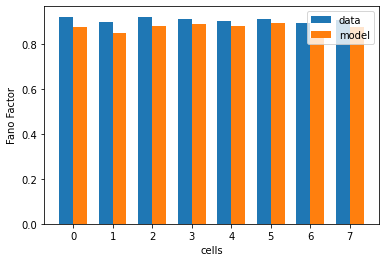

0.0003976550048060059


In [6]:
binomial_para = [1.42, 1.62, 1.66, 1.76, 1.54, 1.99, 1.90, 2.04]
t_list = [3, 3, 4, 4, 3, 4, 3, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 112, [1., 0., 0., 0.], seed=21, noise_locs=[3,4,5])
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=2, threshold=0.4, intv=0.3, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=21, thre=2)

min_error = 10
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial, [39, 60])
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

In [8]:
single_trial_bin.sum(), pred_single_trial_try.sum()

(96593.0, 96910)

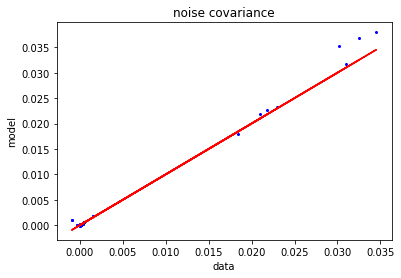

In [7]:
covariance_plot(single_trial_bin, pred_single_trial_try)

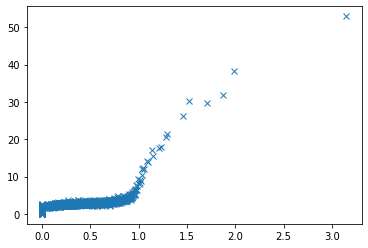

In [21]:
binomial_para = [1.42, 1.62, 1.66, 1.76, 1.54, 1.99, 1.90, 2.04]
t_list = [3, 3, 4, 4, 3, 4, 3, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 112, [1., 0., 0., 0.], seed=21, noise_locs=[3,4,5])
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=2, threshold=0.4, intv=0.3, sigma=True)

time = 1527
x = TestDataset(cfg)[time:time+1][0].to(device)

w, v = compute_cov_eigen(model, x, device, binomial_para, t_list, poly_paras, pred[time: time+1], n_repeats=1500, gaussian=[1.,0.,0.,0.], thre=2)
norm_grads = compute_grad_norm(model, x, device, v)

plt.plot(np.sqrt(w), norm_grads, 'x')

In [20]:
pred[1527]

array([ 6.842977 , 18.853273 , 21.320797 , 13.846573 , 10.46954  ,
       36.56101  ,  5.3160777, 14.781659 ], dtype=float32)